In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from IPython.display import HTML
from matplotlib import animation
from pyhank import qdht, iqdht, HankelTransform

In [2]:
def NormConst(wfn_matrix, R_meshgrid, dR, dZ):
  Norm = 2*np.pi*np.sum((np.abs(wfn_matrix)**2)*R_meshgrid)*dR*dZ
  return Norm 

In [3]:
def Gnd_state_GPE_Cavity(r_max, z_max, t_step, omega_r, omega_z, V_depth, g_intr, V_trans, Trans_width, Del_c, pump, decay_cnst):
  #Grid Parameters
  dt = t_step
  dr = 0.1
  dz = 0.1
  rmax = r_max   #25
  zmax = z_max   #25

  r =  np.arange(0.0, rmax + dr, dr)
  z =  np.arange(-1*zmax, zmax + dz, dz)

  [Z, R] = np.meshgrid(z, r)

  #Setting for Hankel and Fourier respectively
  transformer = HankelTransform(order=0, radial_grid=r)

  k_r = transformer.kr

  #Kz-grid Parameters

  Nz = len(z)
  kz = 2*np.pi*np.fft.fftfreq(Nz, dz)

  #Kinetic Part
  [Kz, Kr]  = np.meshgrid(kz, k_r)
  Krz       = 0.5*(Kz**2 + Kr**2)

  #Potential Part

  #Harmonic Trap
  omegr = omega_r           #radial angular freq
  omegz = omega_z           #axial angular freq

  V_har_r = (omegr/2)*(R**2)               #radial harmonic trap
  V_har_z = (omegz/2)*(Z**2)               #axial harmonic trap

  #Periodic Optical lattice
  Vp = V_depth                              #depth of lattice
  V_periodic_z = Vp*((np.cos(Z))**2)        #lattice potential

  #Gross-Pitaevskii Interaction value
  g = g_intr                                #strength of interaction/contact potential

  #Transverse Coupling
  V_tp  = V_trans                             
  w     = Trans_width                                     #Transverse width
  V_trans_periodic = V_tp*np.exp((-1*R**2)/w**2)*((np.cos(Z))**2) 

  #Cavity Parameters
  Delta_c = Del_c
  Gamma = V_trans                          # = V_tp
  eta = pump
  kappa = decay_cnst

  sigmar_sq  = 0.5 
  sigmaz_sq  = 0.6
  Psi_ini  =  np.exp(-1*(R - 3.0)**2/sigmar_sq)*np.exp(-1*(Z - 2.0)**2/sigmaz_sq)
  Norm_ini = NormConst(Psi_ini, R, dr, dz)
  Psi_gnd  = Psi_ini/np.sqrt(Norm_ini)

  E_diff = 1.0
  mu_Eold = 0.0
  mu_E = 0.0
  iter = 0


  while E_diff > 1e-7:
    bar_Delta_c = Delta_c - 2*np.pi*Gamma*(np.sum(R*np.exp((-1*R**2)/w**2)*((np.cos(Z))**2)*(np.abs(Psi_gnd)**2))*dr*dz)
    alpha_st    = eta/(kappa - 1j*bar_Delta_c)
    Vrz       = V_har_r + V_har_z + V_periodic_z + g*(np.abs(Psi_gnd)**2) + (np.abs(alpha_st)**2)*V_trans_periodic
    Psi_Ur    = Psi_gnd*np.exp(-1*Vrz*dt/2)
    Psi_ftz   = np.fft.fft(Psi_Ur, axis = 1)
    Psi_ftz   = transformer.to_transform_r(Psi_ftz, axis = 0)
    Psi_Htr   = transformer.qdht(Psi_ftz, axis = 0)
    Psi_Kr    = Psi_Htr*np.exp(-1*Krz*dt)
    Psi_iftz  = np.fft.ifft(Psi_Kr, axis = 1)
    Psi_iHtr  = transformer.iqdht(Psi_iftz, axis = 0)
    Psi_iHtr  = transformer.to_original_r(Psi_iHtr, axis = 0)
    Psi_gnd   = Psi_iHtr*np.exp(-1*Vrz*dt/2)
    norm      = NormConst(Psi_gnd, R, dr, dz)
    Psi_gnd   = Psi_gnd/np.sqrt(norm)
    mu_E      = -np.log(norm)/(2.0*dt)
    E_diff    = np.abs(mu_E - mu_Eold)
    mu_Eold   = mu_E
    
    iter = iter + 1
    #print(mu_E)

  print("Gnd state Energy:", mu_E)

  return Psi_gnd, alpha_st


In [4]:
def Sinstep_Split_Op(Psi0, t_step, r_max, z_max, omega_r, omega_z, V_depth, alpha_t, V_trans, Trans_width, Force, g_intr):
  #time parameters
  dt = t_step

  #Grid Parameters
  dr = 0.1                    #0.05       #0.1
  dz = 0.1
  rmax = r_max
  zmax = z_max

  r =  np.arange(0.0, rmax + dr, dr)
  z =  np.arange(-1*zmax, zmax + dz, dz)

  [Z, R] = np.meshgrid(z, r)

  #Setting for Hankel and Fourier respectively
  transformer = HankelTransform(order=0, radial_grid=r)

  k_r = transformer.kr

  #Kz-grid Parameters

  Nz = len(z)
  kz = 2*np.pi*np.fft.fftfreq(Nz, dz)

  #Kinetic Part
  [Kz, Kr]  = np.meshgrid(kz, k_r)
  Krz       = 0.5*(Kz**2 + Kr**2)

  #Potential Part
  #Harmonic Trap
  omegr = omega_r           #radial angular freq
  omegz = omega_z           #axial angular freq

  V_har_r = (omegr/2)*(R**2)               #radial harmonic trap
  V_har_z = (omegz/2)*(Z**2)               #axial harmonic trap

  #Periodic Optical lattice
  Vp = V_depth                              #depth of lattice
  V_periodic_z = Vp*((np.cos(Z))**2)        #lattice potential
    
  #Transverse Coupling
  V_tp  = V_trans                             
  w     = Trans_width                                     #Transverse width
  V_trans_periodic = V_tp*np.exp((-1*R**2)/w**2)*((np.cos(Z))**2) 

  #Force along axial (Z)
  F0 = Force
  V_force = F0*Z

  #Gross-Pitaevskii Interaction value
  g = g_intr                                #strength of interaction/contact potential

  Psi0 /= np.sqrt(NormConst(Psi0, R, dr, dz)) 

  Vrz       = V_har_r + V_har_z + V_periodic_z + V_force + V_trans_periodic*(np.abs(alpha_t)**2) + g*(np.abs(Psi0)**2)
  Psi0     *= np.exp(-1j*Vrz*dt/2)
  Psi0      = np.fft.fft(Psi0, axis = 1)
  Psi0      = transformer.to_transform_r(Psi0, axis = 0)
  Psi0      = transformer.qdht(Psi0, axis = 0)
  Psi0     *= np.exp(-1j*Krz*dt)
  Psi0      = np.fft.ifft(Psi0, axis = 1)
  Psi0      = transformer.iqdht(Psi0, axis = 0)
  Psi0      = transformer.to_original_r(Psi0, axis = 0)
  Psi0     *= np.exp(-1j*Vrz*dt/2)


  return Psi0

Gnd state Energy: 2.2334163083816576
1.0000359054511614
0.9999862993564467
1.0000213271012934
1.000004324166011
0.9999900449016537
1.0000220973960958
0.999999830359492
0.9999940521279056
1.000021864367791
0.9999964164964527


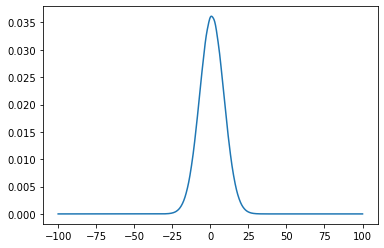

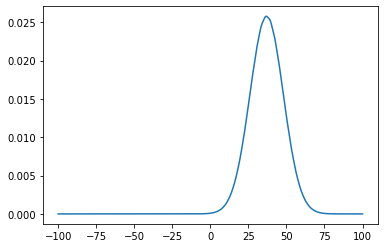

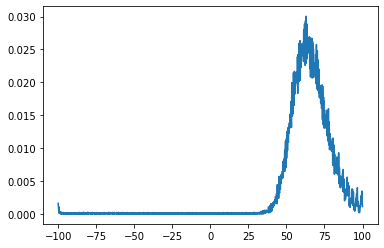

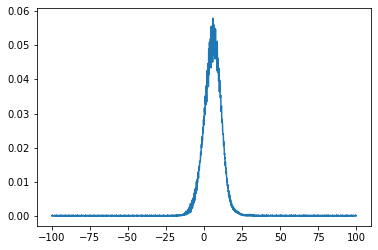

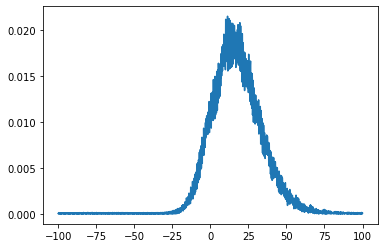

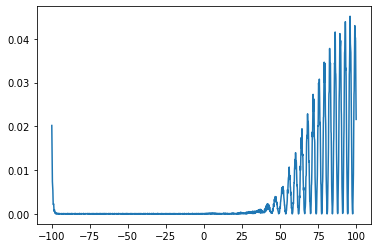

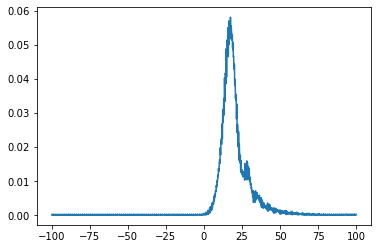

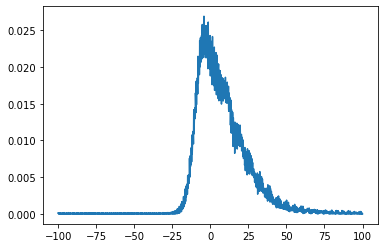

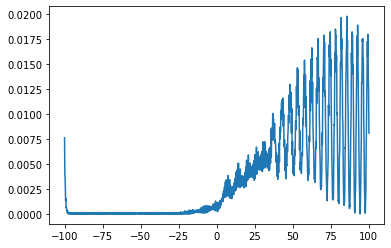

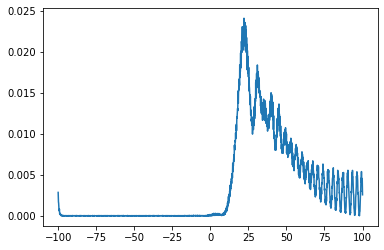

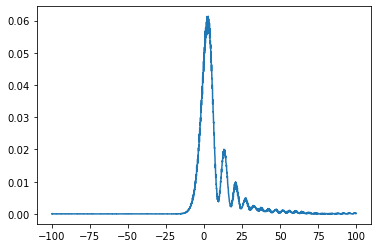

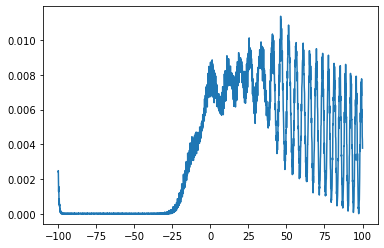

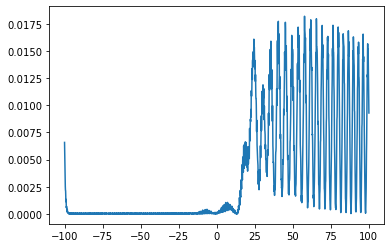

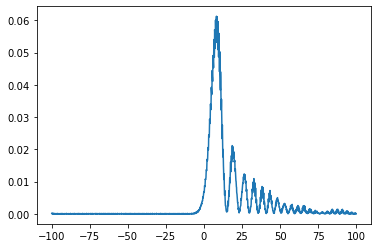

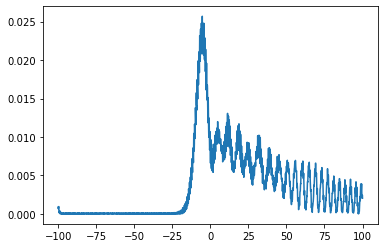

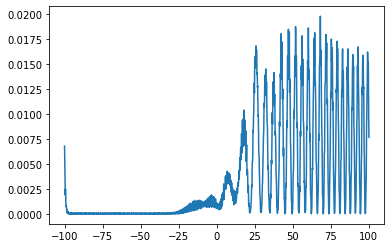

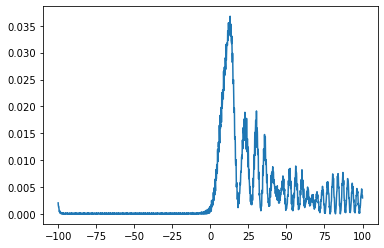

<Figure size 432x288 with 0 Axes>

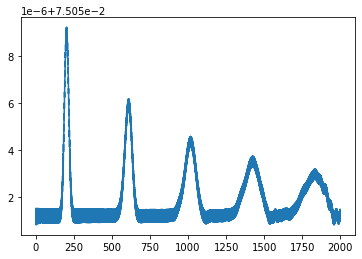

In [5]:
"""
def Imaginary_Time(r_max, z_max, t_step, omega_r, omega_z, V_depth, g_intr):

def Sinstep_Split_Op(Psi0, t_step, r_max, z_max, omega_r, omega_z, V_depth, Force, g_intr):

"""
iter_time = np.arange(0, 20000)

dt = 0.1
t =  dt*iter_time

dr = 0.1
dz = 0.1
rmax = 5.0
zmax = 100.0

r =  np.arange(0.0, rmax + dr, dr)
z =  np.arange(-1*zmax, zmax + dz, dz)

[Z, R] = np.meshgrid(z, r)


#Psi Parameters
omeg_r = 5.0
omeg_z = 5e-5
#Vp = 2.0
F = -0.005
g_int = 1e-3
Gamma = -2.0
w = 0.1

#Cavity Parameters
Del_c = 3.0
pump = 5.0
decay_cnst = 18.0 
eta = pump

"""
def Gnd_state_GPE_Cavity(r_max, z_max, t_step, omega_r, omega_z, V_depth, g_intr, Trans_coupl, Trans_width, Del_c, gamma, pump, decay_cnst):
def Sinstep_Split_Op(Psi0, t_step, r_max, z_max, omega_r, omega_z, V_depth, alpha_t, V_trans, Trans_width, Force, g_intr):
"""
alpha_t = np.zeros(len(t), dtype=complex)


Psi0, alpha0 = Gnd_state_GPE_Cavity(rmax, zmax, dt, omeg_r, omeg_z, 0.0, g_int, Gamma, w, Del_c, pump, decay_cnst)

alpha_t[0] = alpha0 

for i in iter_time:
    if i < iter_time[-1]:
        Psi0 = Sinstep_Split_Op(Psi0, dt, rmax, zmax, omeg_r, 0.0, 0.0, alpha_t[i], Gamma, w, F, g_int)
        bar_Delta_c = Del_c - 2*np.pi*Gamma*(np.sum(R*np.exp((-1*R**2)/w**2)*((np.cos(Z))**2)*(np.abs(Psi0)**2))*dr*dz)
        tau       =  -1*decay_cnst + 1j*bar_Delta_c
        alpha_t[i+1] = alpha_t[i]*np.exp(tau*i*dt) + (eta/tau)*(np.exp(tau*i*dt) - 1)

        if i % 2000 == 0:
            print(NormConst(Psi0, R, dr, dz))

        if i % 1200 == 0:
            plt.plot(z, np.abs(Psi0[0, :])**2)
            plt.figure()
                #plt.suptitle(r"Bloch Oscillation - $|\Psi(r = 0, z)|^2$ at $\tilde{t} = %0.1f$, " % float(i*dt))
    #             plt.title(r"Bloch Oscillation - $|\Psi(r = 0, z)|^2$ at $\tilde{t} = %0.1f$, " % float(i*dt) + r"for $\alpha_r = %0.1f,$" % omeg_r + r"$\alpha_z = %f$, " % omeg_z + r"$\tilde{V}_p = %0.1f,$" % Vp + r"$\tilde{F} = %0.3f$" % F)
    #             plt.xlabel(r"$\tilde{z}$")
    #             plt.ylabel(r"$|\Psi(r = 0, z)|^2$")
    #             plt.figure()

plt.figure()
plt.plot(t[0:len(t) - 10], np.abs(alpha_t[0:len(t) - 10])**2)

    
        